### customer
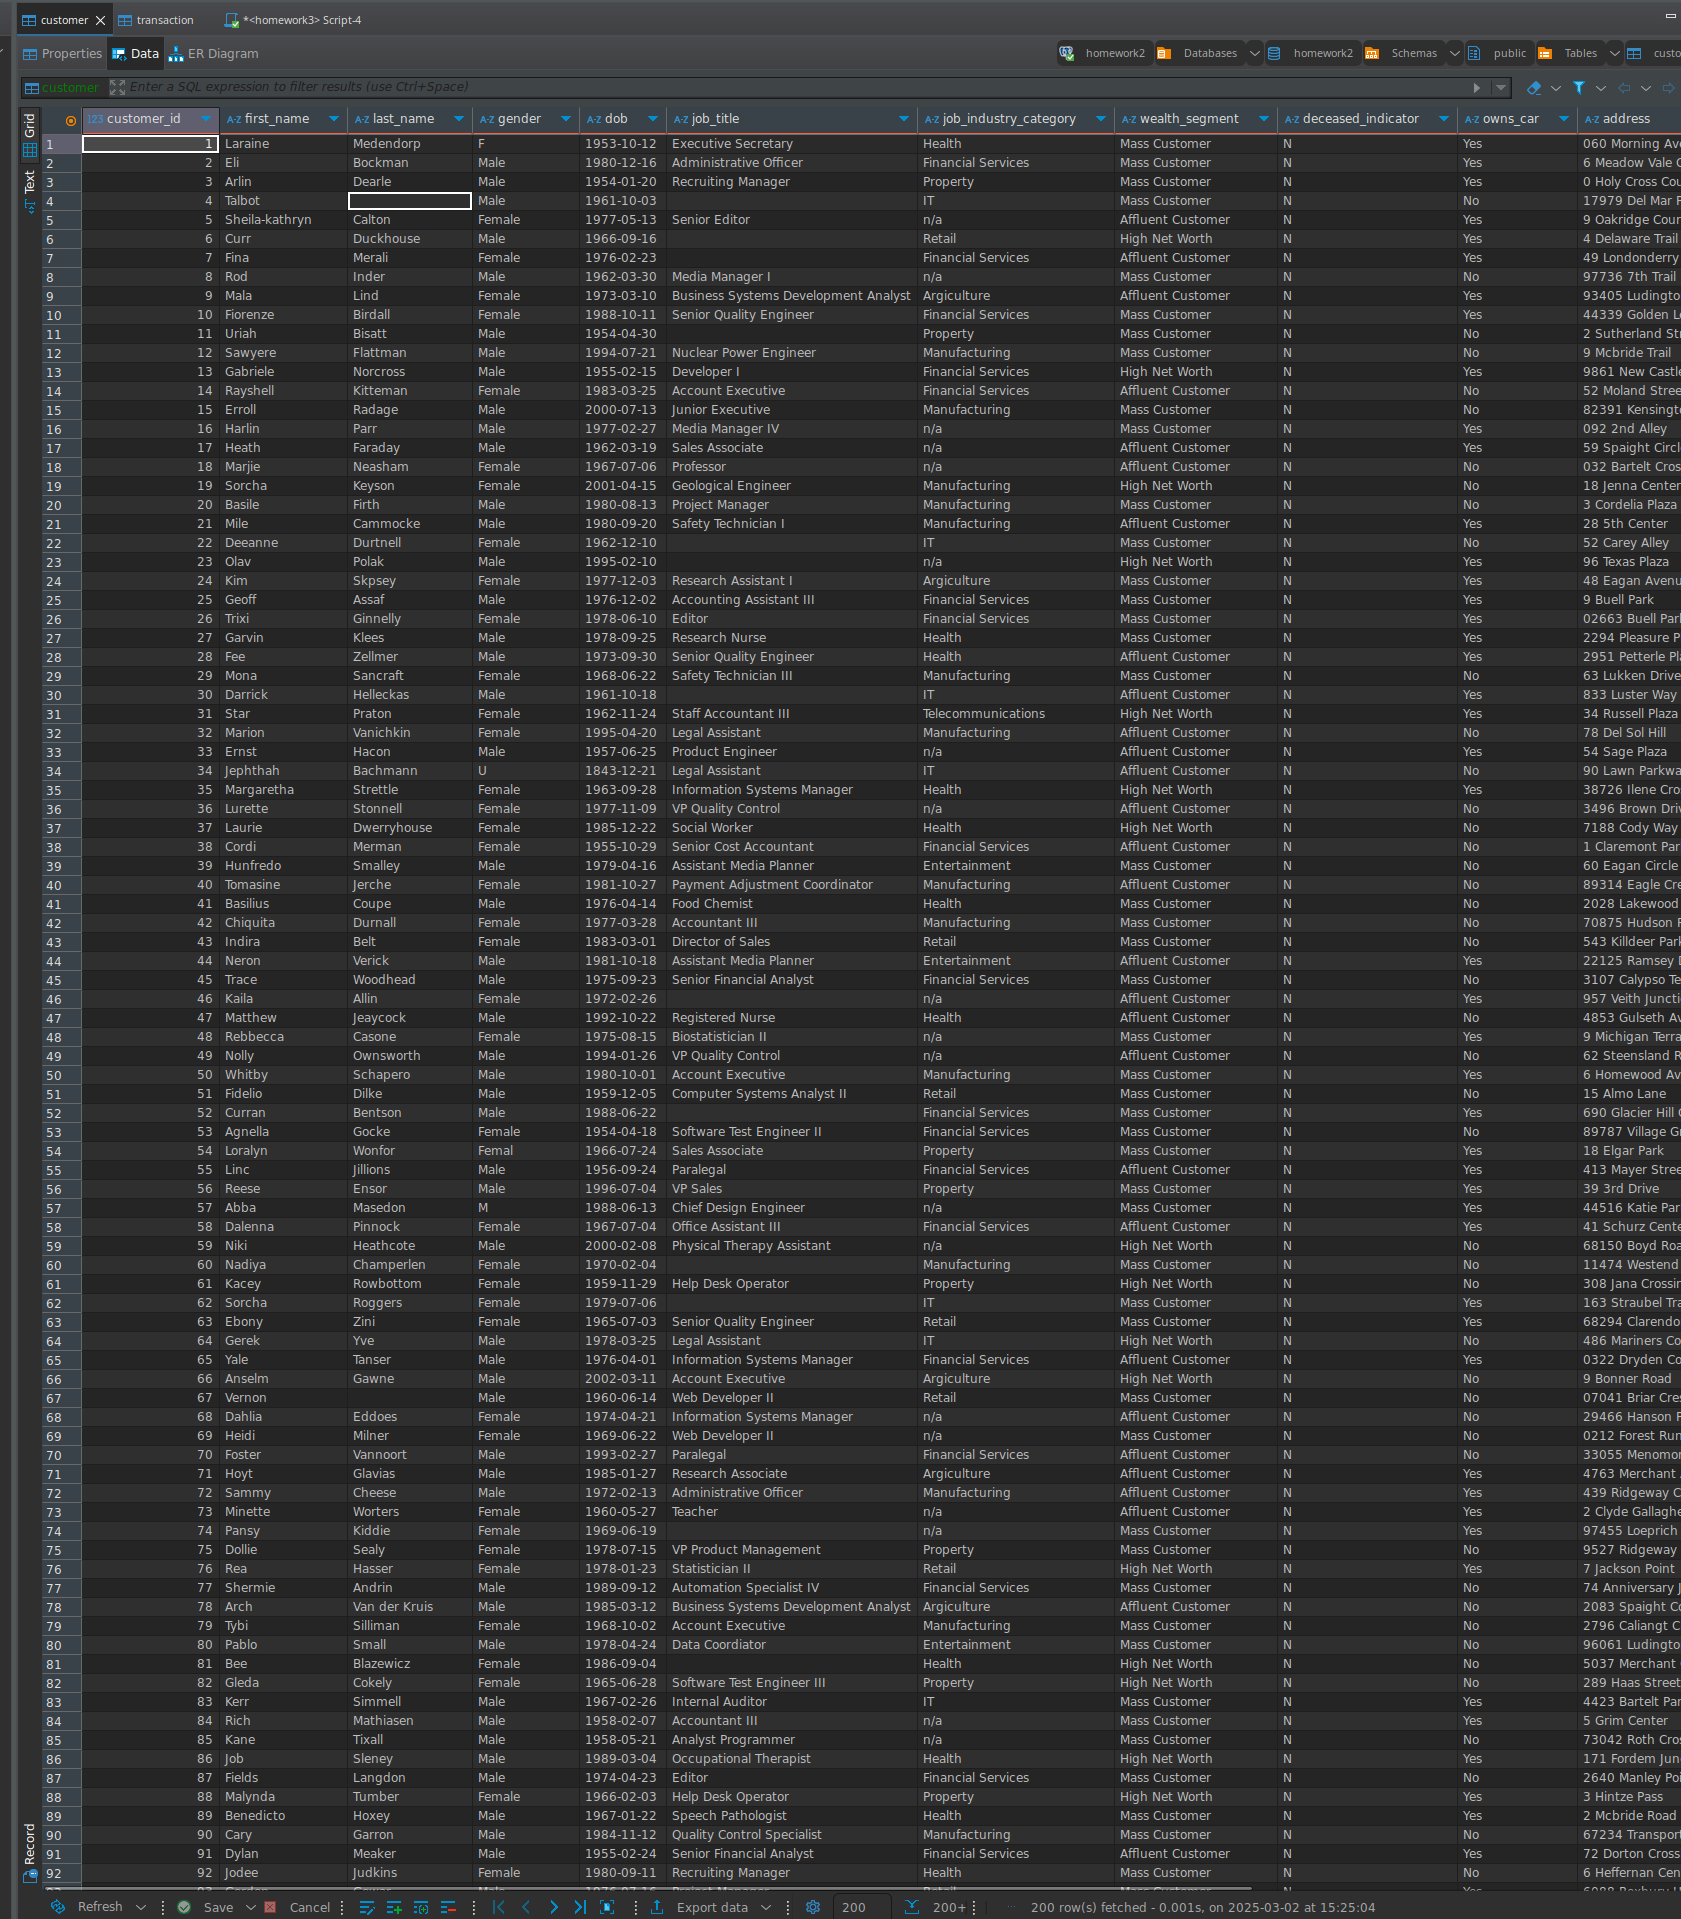
### transaction
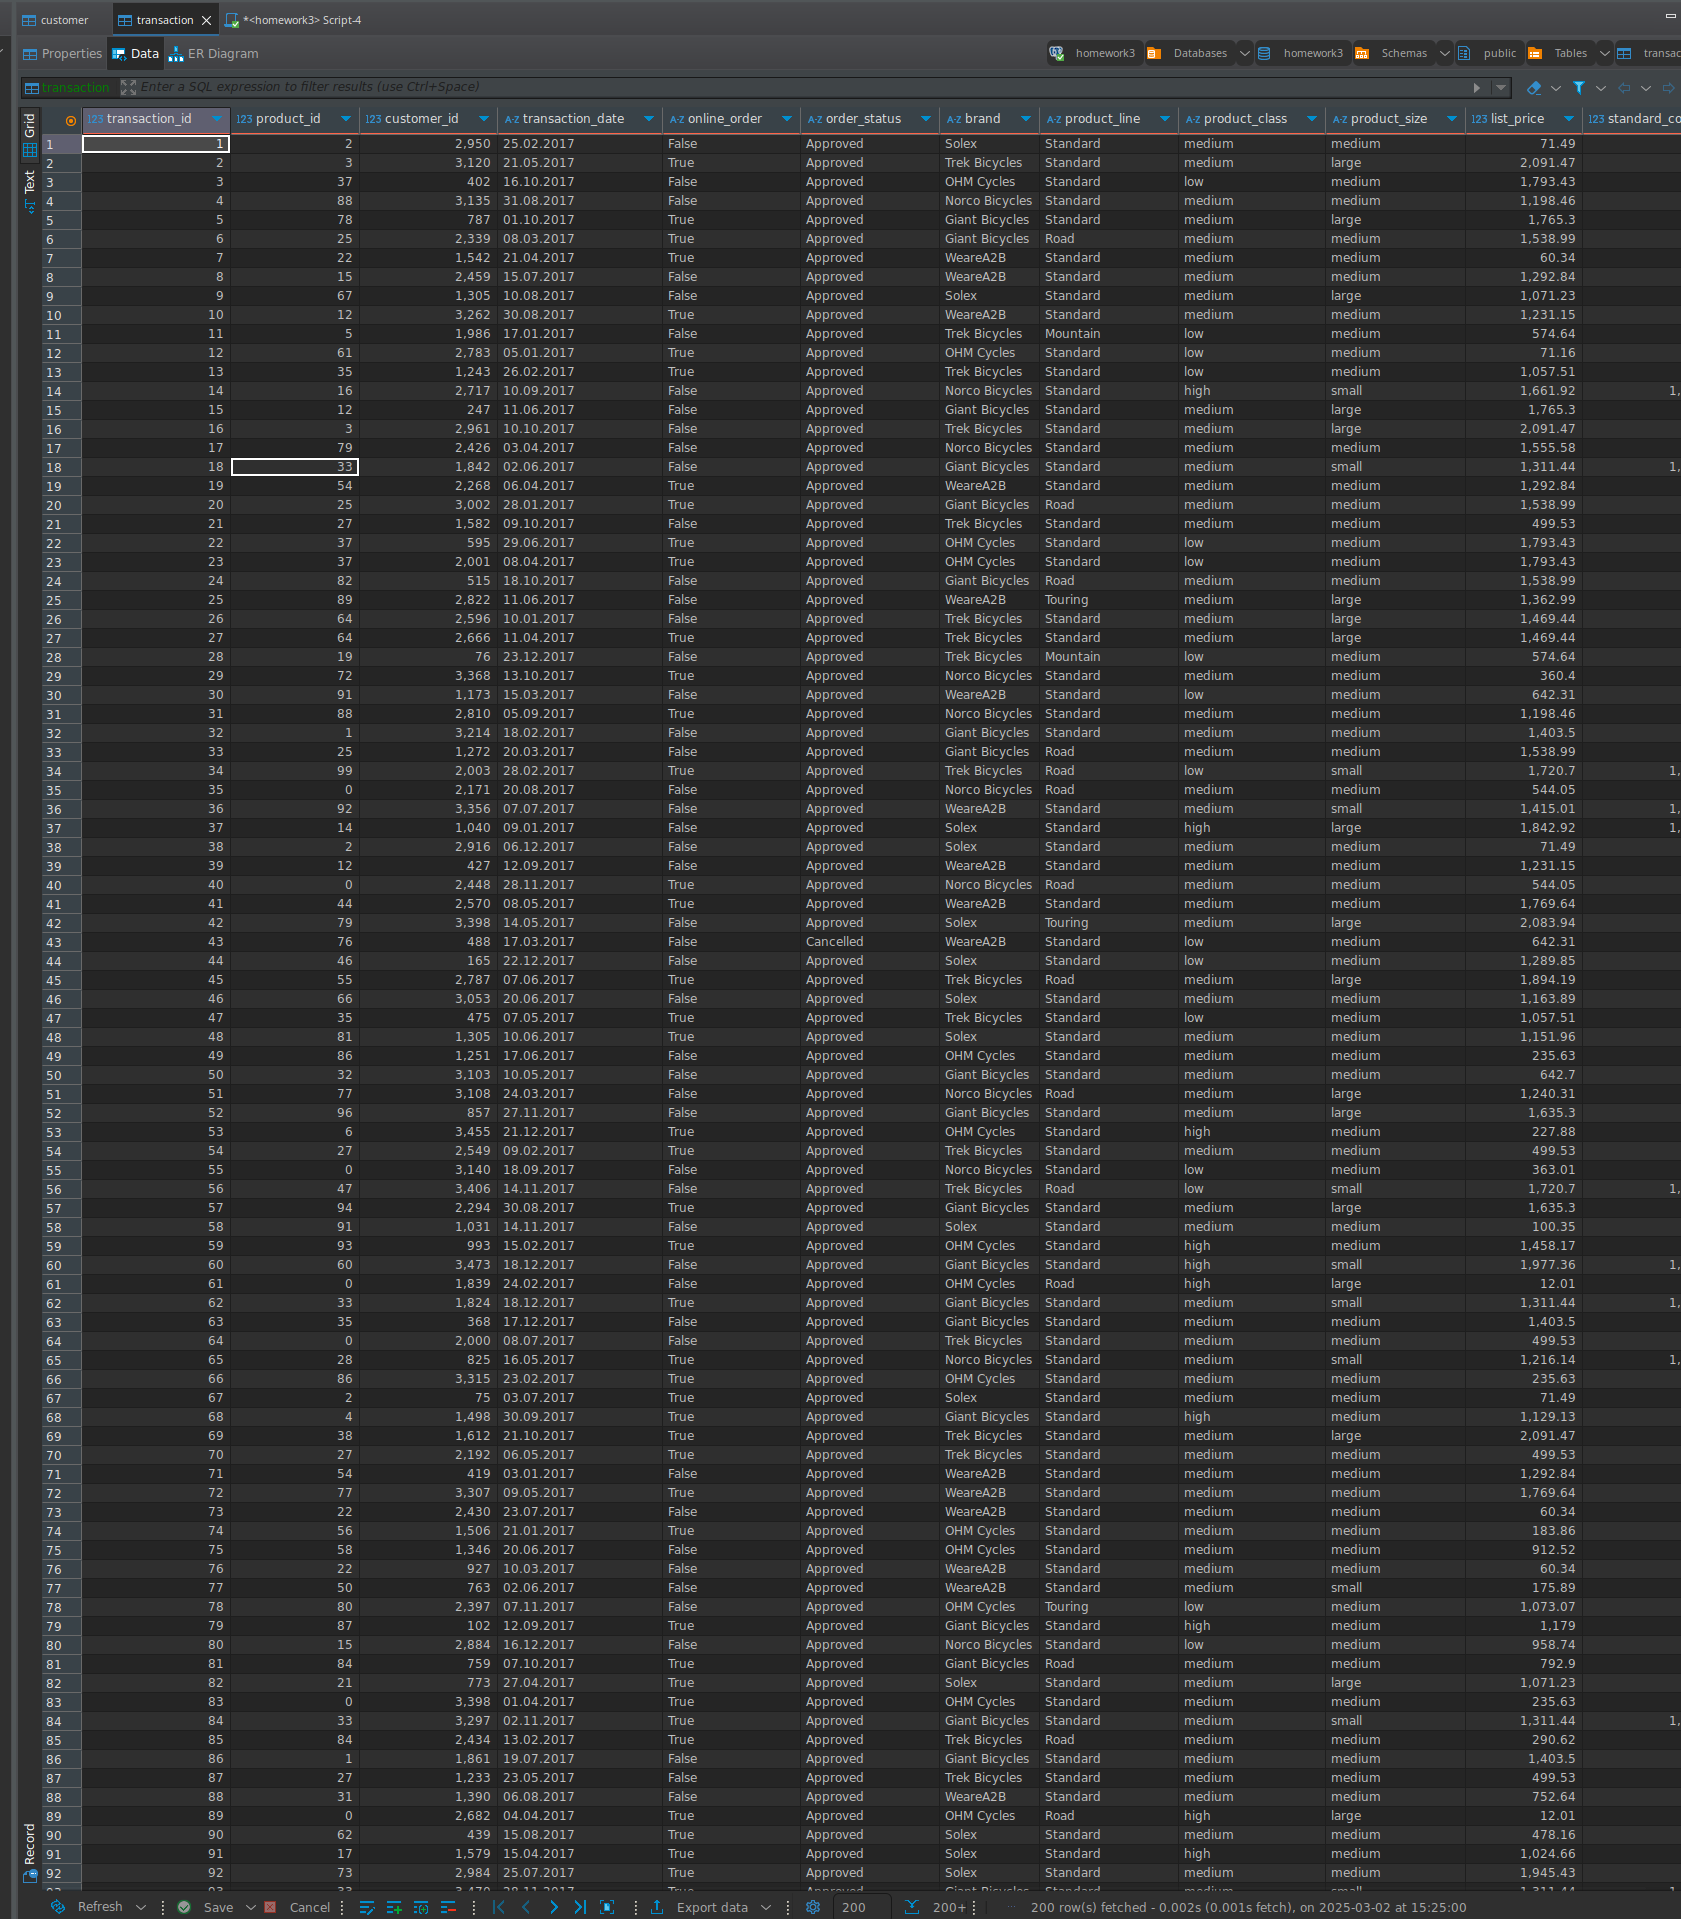


### Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.
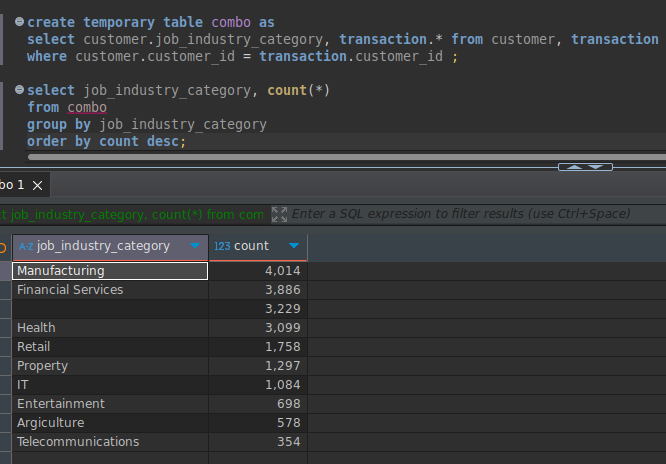
```sql
create temporary table combo as 
select customer.job_industry_category, transaction.* from customer, transaction
where customer.customer_id = transaction.customer_id ;

select job_industry_category, count(*)
from combo
group by job_industry_category
order by count desc;
```

### Найти сумму транзакций за каждый месяц по сферам деятельности, отсортировав по месяцам и по сфере деятельности. 
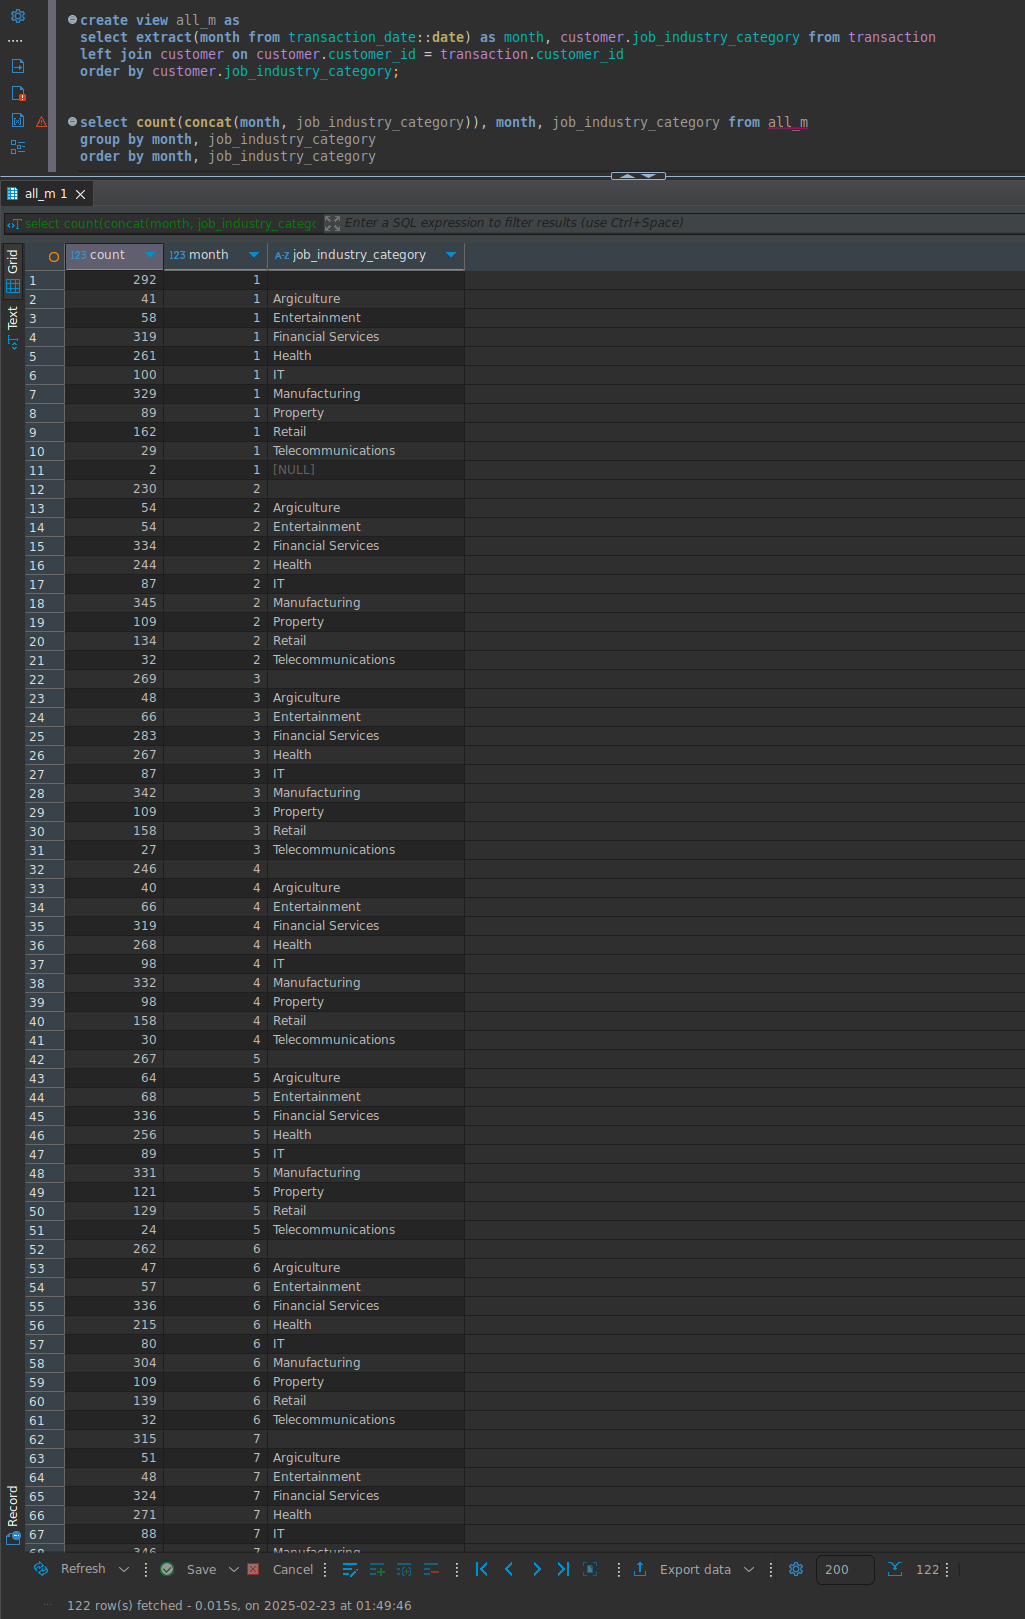

```sql
create view all_m as
select extract(month from transaction_date::date) as month, customer.job_industry_category from transaction
left join customer on customer.customer_id = transaction.customer_id 
order by customer.job_industry_category;


select count(concat(month, job_industry_category)), month, job_industry_category from all_m
group by month, job_industry_category
order by month, job_industry_category
```

### Вывести количество онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT.
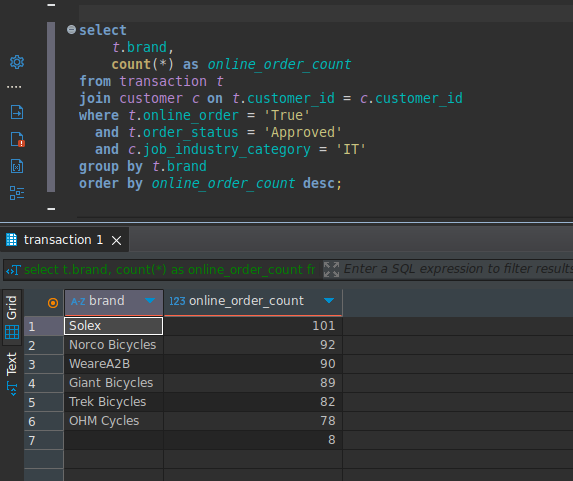

```sql
select 
    t.brand, 
    count(*) as online_order_count
from transaction t
join customer c on t.customer_id = c.customer_id
where t.online_order = 'True'
  and t.order_status = 'Approved'
  and c.job_industry_category = 'IT'
group by t.brand
order by online_order_count desc;
```

### Найти по всем клиентам сумму всех транзакций (list_price), максимум, минимум и количество транзакций, отсортировав результат по убыванию суммы транзакций и количества клиентов. Выполните двумя способами: используя только group by и используя только оконные функции. Сравните результат.
#### 4.1
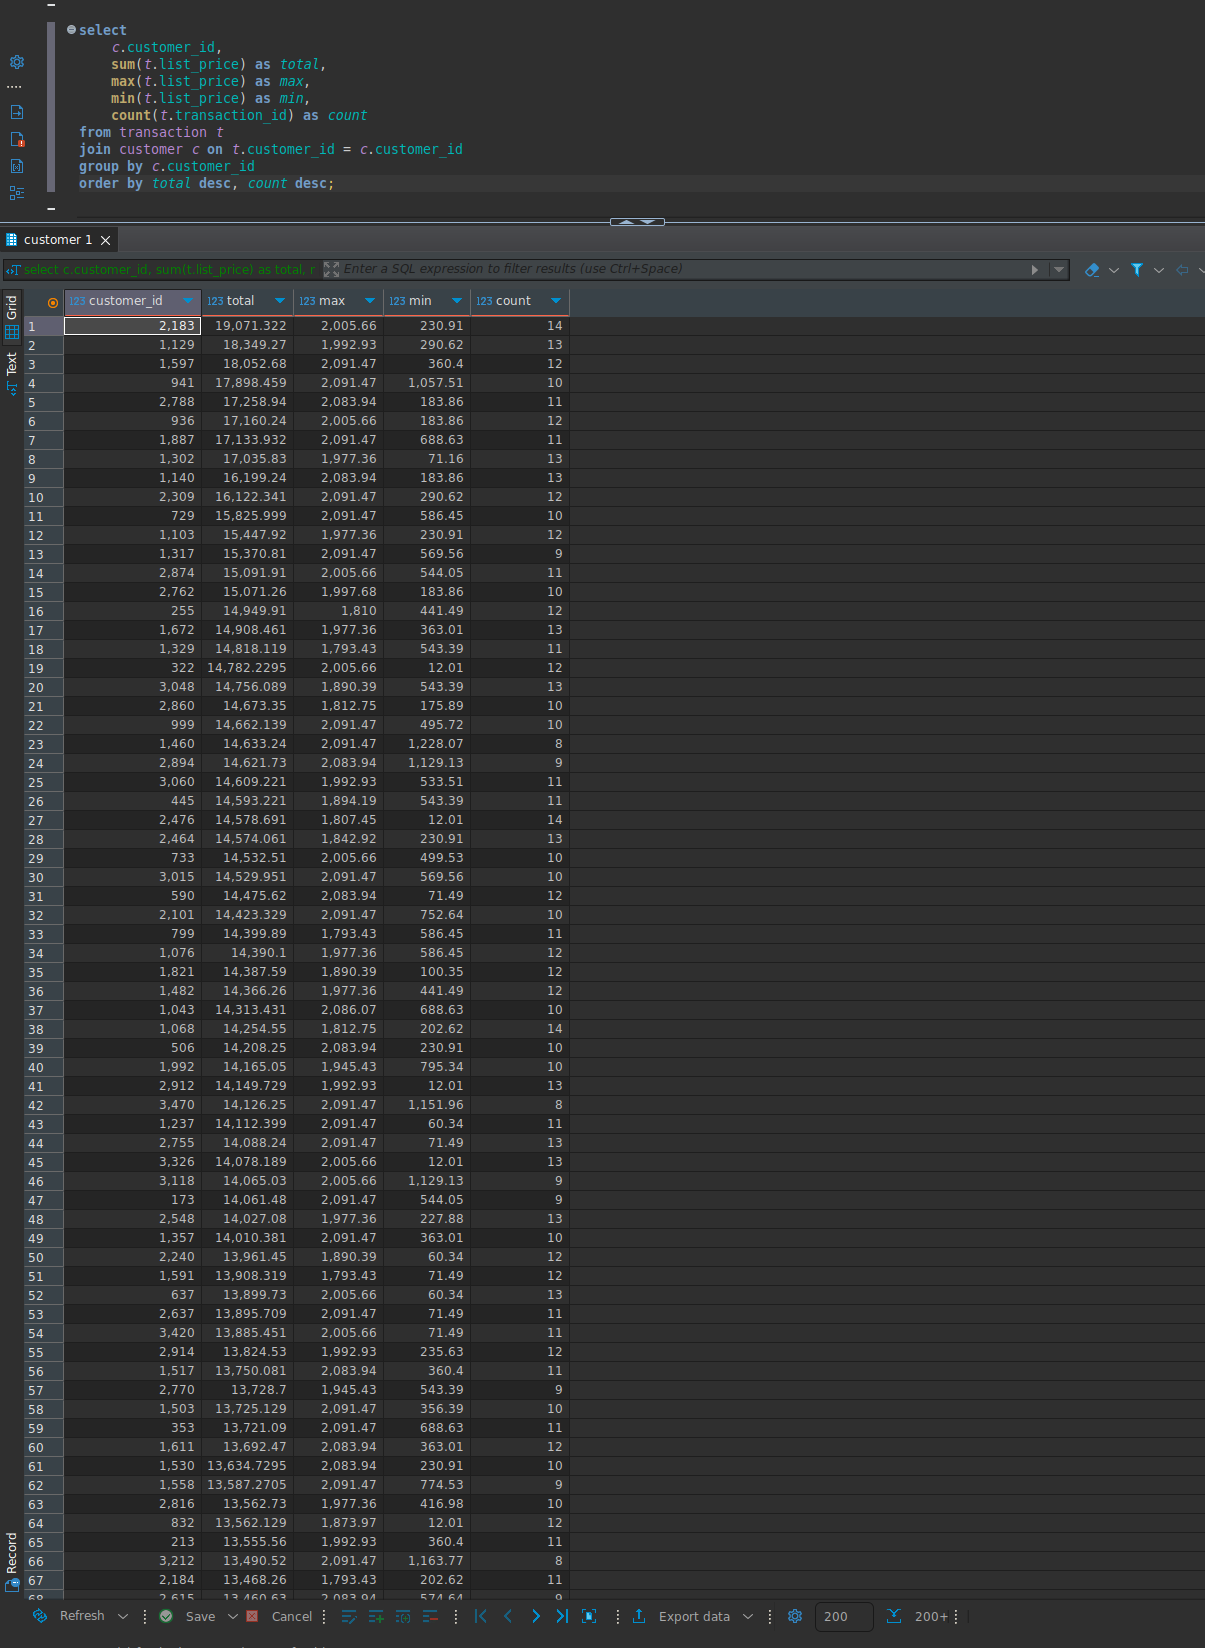
```sql
select 
    c.customer_id,
    sum(t.list_price) as total,
    max(t.list_price) as max,
    min(t.list_price) as min,
    count(t.transaction_id) as count
from transaction t
join customer c on t.customer_id = c.customer_id
group by c.customer_id
order by total desc, count desc;
```

#### 4.2
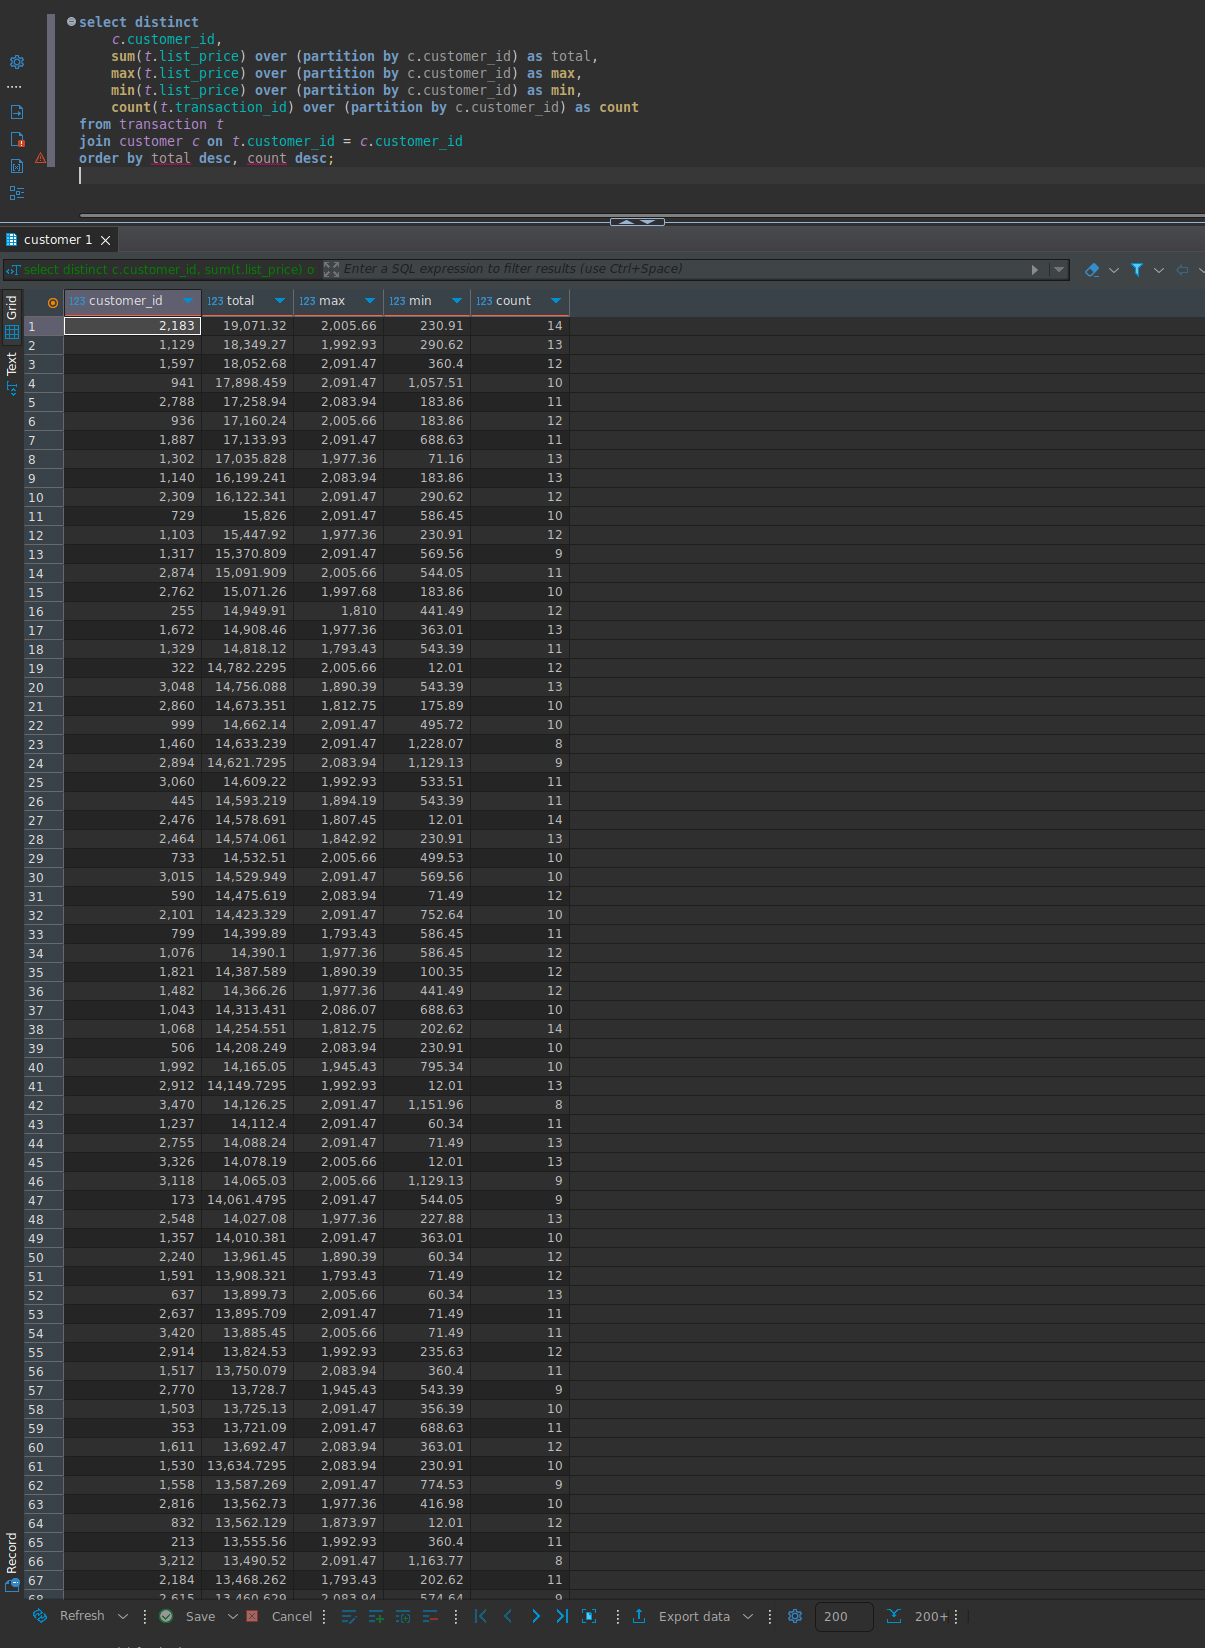
```sql
select distinct 
    c.customer_id,
    sum(t.list_price) over (partition by c.customer_id) as total,
    max(t.list_price) over (partition by c.customer_id) as max,
    min(t.list_price) over (partition by c.customer_id) as min,
    count(t.transaction_id) over (partition by c.customer_id) as count
from transaction t
join customer c on t.customer_id = c.customer_id
order by total desc, count desc;
```

### Найти имена и фамилии клиентов с минимальной/максимальной суммой транзакций за весь период (сумма транзакций не может быть null). Напишите отдельные запросы для минимальной и максимальной суммы. 
#### 5.1
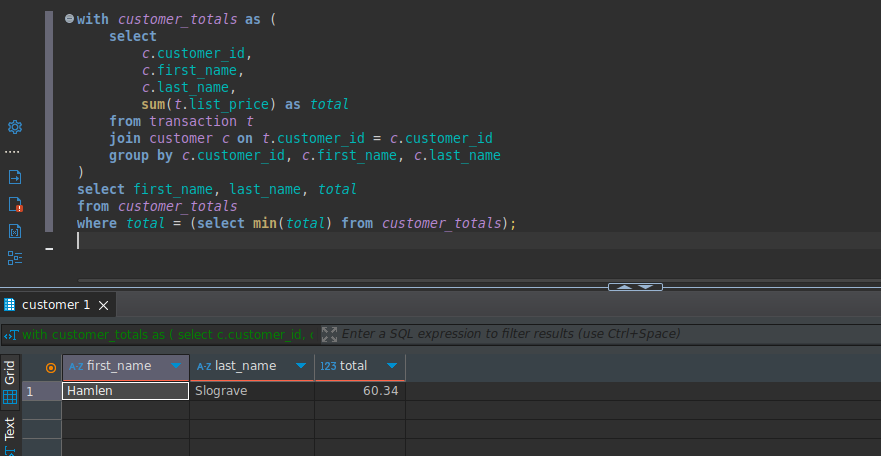
```sql
with customer_totals as (
    select 
        c.customer_id,
        c.first_name,
        c.last_name,
        sum(t.list_price) as total
    from transaction t
    join customer c on t.customer_id = c.customer_id
    group by c.customer_id, c.first_name, c.last_name
)
select first_name, last_name, total
from customer_totals
where total = (select min(total) from customer_totals);
```

#### 5.2
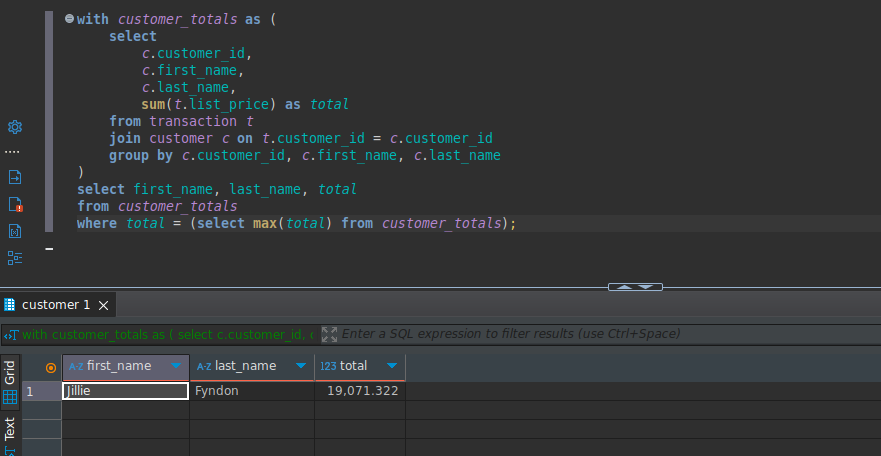
```sql
with customer_totals as (
    select 
        c.customer_id,
        c.first_name,
        c.last_name,
        sum(t.list_price) as total
    from transaction t
    join customer c on t.customer_id = c.customer_id
    group by c.customer_id, c.first_name, c.last_name
)
select first_name, last_name, total
from customer_totals
where total = (select max(total) from customer_totals);
```

### Вывести только самые первые транзакции клиентов. Решить с помощью оконных функций. 
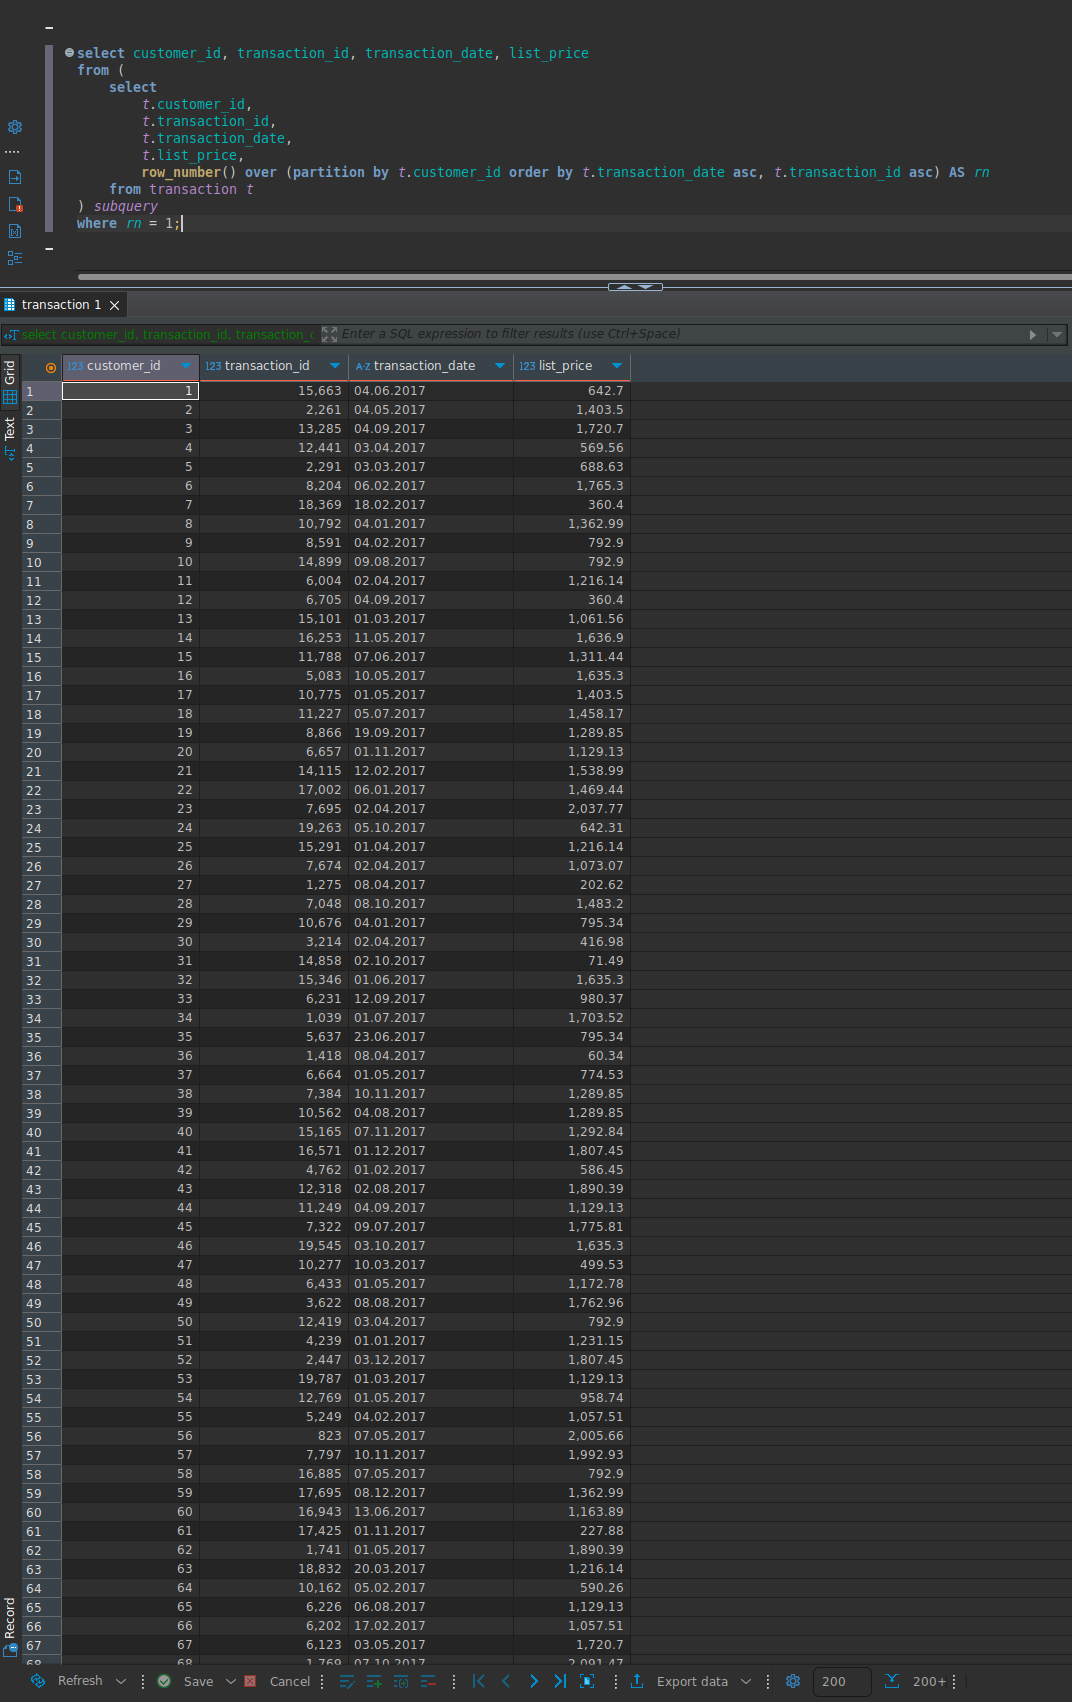
```sql
select customer_id, transaction_id, transaction_date, list_price
from (
    select 
        t.customer_id,
        t.transaction_id,
        t.transaction_date,
        t.list_price,
        row_number() over (partition by t.customer_id order by t.transaction_date asc, t.transaction_id asc) AS rn
    from transaction t
) subquery
where rn = 1;
```

### Вывести имена, фамилии и профессии клиентов, между транзакциями которых был максимальный интервал (интервал вычисляется в днях) 

```sql
with transaction_intervals as (
    select 
        t.customer_id,
        c.first_name,
        c.last_name,
        c.job_title,
        t.transaction_date,
        lag(t.transaction_date) over (partition by t.customer_id order by t.transaction_date) as prev_transaction_date,
        (t.transaction_date - lag(t.transaction_date) over (partition by t.customer_id order by t.transaction_date)) as transaction_gap
    from transaction t
    join customer c on t.customer_id = c.customer_id
)
select first_name, last_name, job_title, transaction_gap
from transaction_intervals
where transaction_gap = (select max(transaction_gap) from transaction_intervals);
```
